# BI-PRS - Semestral Work 1

### Country selection according to the representant's data

In [1]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Norsko, K.Dedecius')

Parameter M = 2 => Norsko, K.Dedecius

### Neccessary imports

In [2]:
library(cowplot)
library(eurostat)
library(ggplot2)
library(gridExtra)
library(repr)
library(tibble)
library(tidyr)
library(vtable)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Loading required package: kableExtra



## Dataset preparation

- Download the dataset
- Describe the columns
- Extract relevant data

In [3]:
# Downloading the dataset
dataset <- get_eurostat(id='crim_gen_reg')

Table crim_gen_reg cached at /tmp/Rtmp2RFge5/eurostat/807d30683b11502696f1bedc206d143e.rds



In [4]:
# First glance at the data we've received
head(dataset, 2)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82


#### Column description:

- **freq**: Frequency
- **unit**: Unit of measure
- **iccs**: International classification of crime for statistical purposes
- **geo**: Geopolitical entity (reporting)
- **TIME_PERIOD**: Time
 
[1]

#### Dataset completeness

There are no problems with the completeness of the data for the year $2021$ from Norway.

![completeness](src/images/completeness.png)
[2]

#### Data units of measure explanation

We have multiple units of measure in this dataset. Let's clarify which ones we have here.

![units](src/images/units.png)
[3]

#### Relevant data selection and dataset transformations
- Norway NUTS3 regions
- Records for the year $2021$
- Make separate columns for relative and absolute values
- Make columns iccs and geo factors

In [5]:
# Relative data selection
data <- subset(dataset, 
               startsWith(geo, 'NO') &
               nchar(geo) == 5 &
               TIME_PERIOD == '2021-01-01', 
               c(unit, iccs, geo, values))

#### Rename factor categories
![iccs_codes](src/images/iccs_codes.png)

[4] 

**Not provided in the dataset**:
- Assault (ICCS02011)
- Burglary (ICCS0501)
- Burglary of private residential premises (ICCS05012)

[2]

In [6]:
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Other theft', 'Vehicle theft')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)
prev_labels <- c("NO020", "NO060", "NO071", "NO074", "NO081", "NO082", "NO091", "NO092", "NO0A1", "NO0A2", "NO0A3", "NO0B1", "NO0B2")
new_labels <- c("Innlandet", "Trøndelag", "Nordland", "Troms og Finnmark", "Oslo", "Viken", "Vestfold og Telemark", "Agder", "Rogaland", "Vestland", "Møre og Romsdal", "Jan Mayen", "Svalbard")
data$geo <- factor(data$geo, levels=prev_labels, labels=new_labels)

In [7]:
# Dataset transformation
data_by_unit <- split(data[, -1], data$unit)
all.equal(data_by_unit$P_HTHAB[, 1:2], data_by_unit$NR[, 1:2])

[1] TRUE

In [8]:
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=T)  # outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

In [9]:
any(is.na(data))  # no NA values

[1] FALSE

In [10]:
head(data, 10)

,iccs,geo,rel,abs
,<fct>,<fct>,<dbl>,<dbl>
1,Int. homicide,Agder,0.32,1
2,Int. homicide,Innlandet,0.00,0
3,Int. homicide,Møre og Romsdal,0.75,2
4,Int. homicide,Nordland,0.00,0
5,Int. homicide,Oslo,1.00,7
6,Int. homicide,Rogaland,0.00,0
7,Int. homicide,Troms og Finnmark,0.00,0
8,Int. homicide,Trøndelag,0.21,1
9,Int. homicide,Vestfold og Telemark,0.47,2


In addition to the data processing performed, it is important to note that the values of ICCS050211 are already contained in ICCS0502. We will resolve this from below depending on what the specific test requires.
[6]

## Exploratory data analysis & descriptive statistics

The data we have represent a number of crimes of each specific type for each NUTS3 Norway region represented in P_HTHAB (Per hundred thousand inhabitants) units. To analyse the following data, statistical measures and graphs will be used. As a result, we want to get insights about the criminality in different NUTS3 regions of Norway.

In [11]:
freq_df <- pivot_wider(data[, -4], names_from=iccs, values_from=rel)
freq_df[, 'Other theft'] <- freq_df[, 'Other theft'] - freq_df[, 'Vehicle theft']
freq_table <- (freq_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_table)) <- c('geo', 'iccs')
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

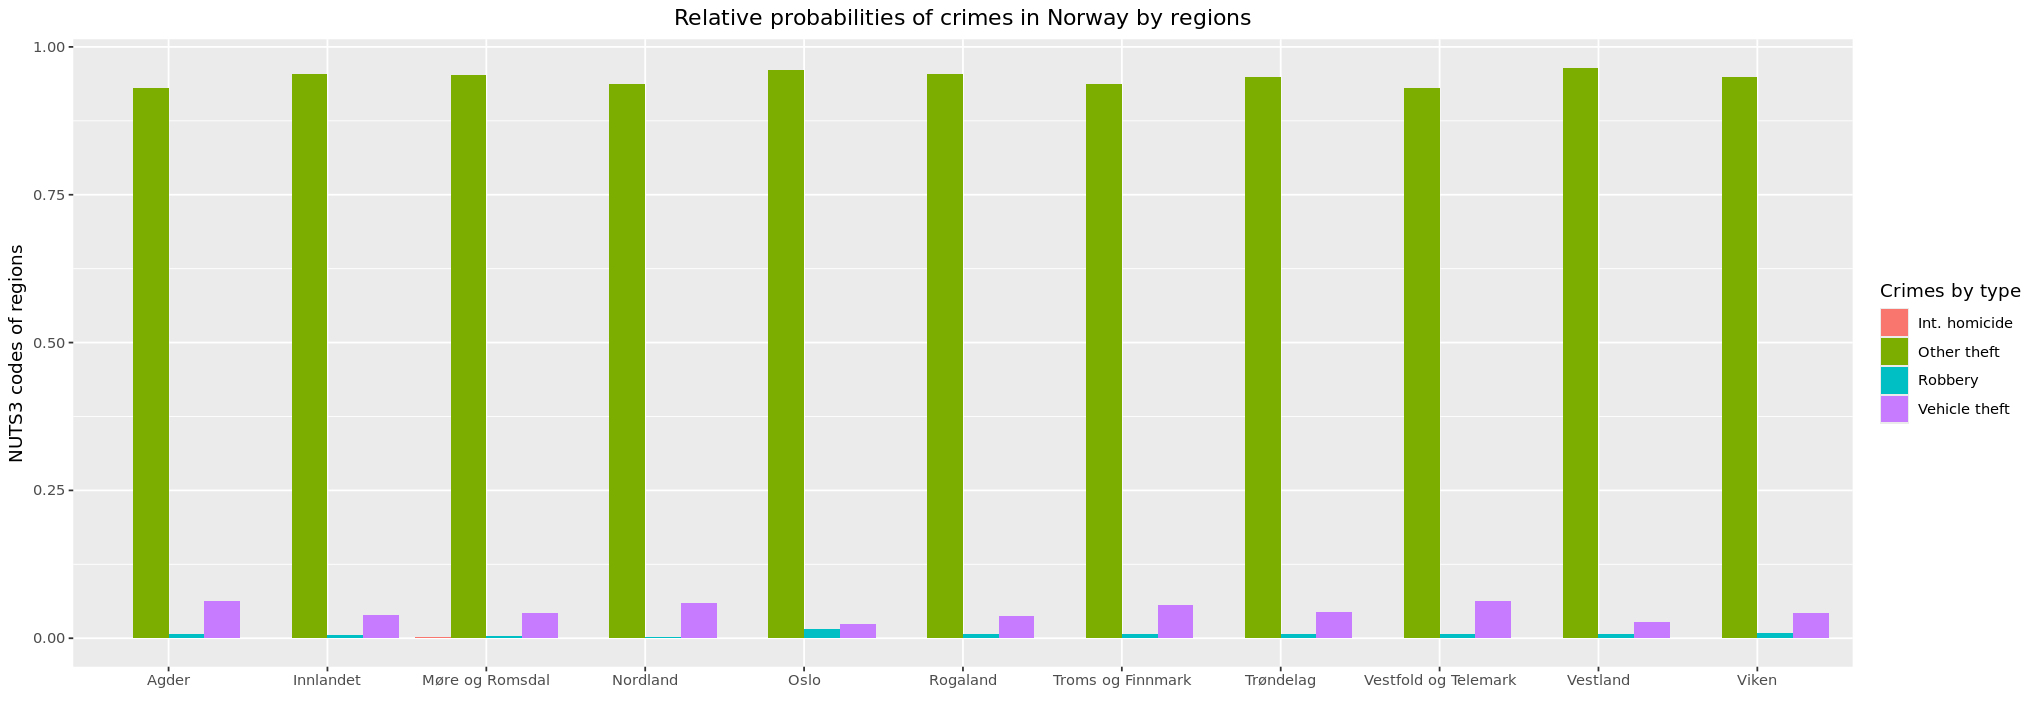

In [12]:
options(repr.plot.width=17, repr.plot.height=6) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by regions', x='', y='NUTS3 codes of regions', # Changes a title & axes of a plot
         fill="Crimes by type" ) + # Changes a title of a legend
    theme(plot.title = element_text(hjust=0.5)) # Centers a title of a plot

What we see from the plot upwards is that **without taking into account the criminality** of a particular NUTS3 region in Norway,
the **distribution of crimes by types** in all regions is **very similar**. That gives us an intuition (tests weren't conducted yet) that
**all crime types** are similarly distributed **in all regions.** We can see that **theft is the most likely-to-happen crime in all regions and an int. homicide is the most rare crime**.

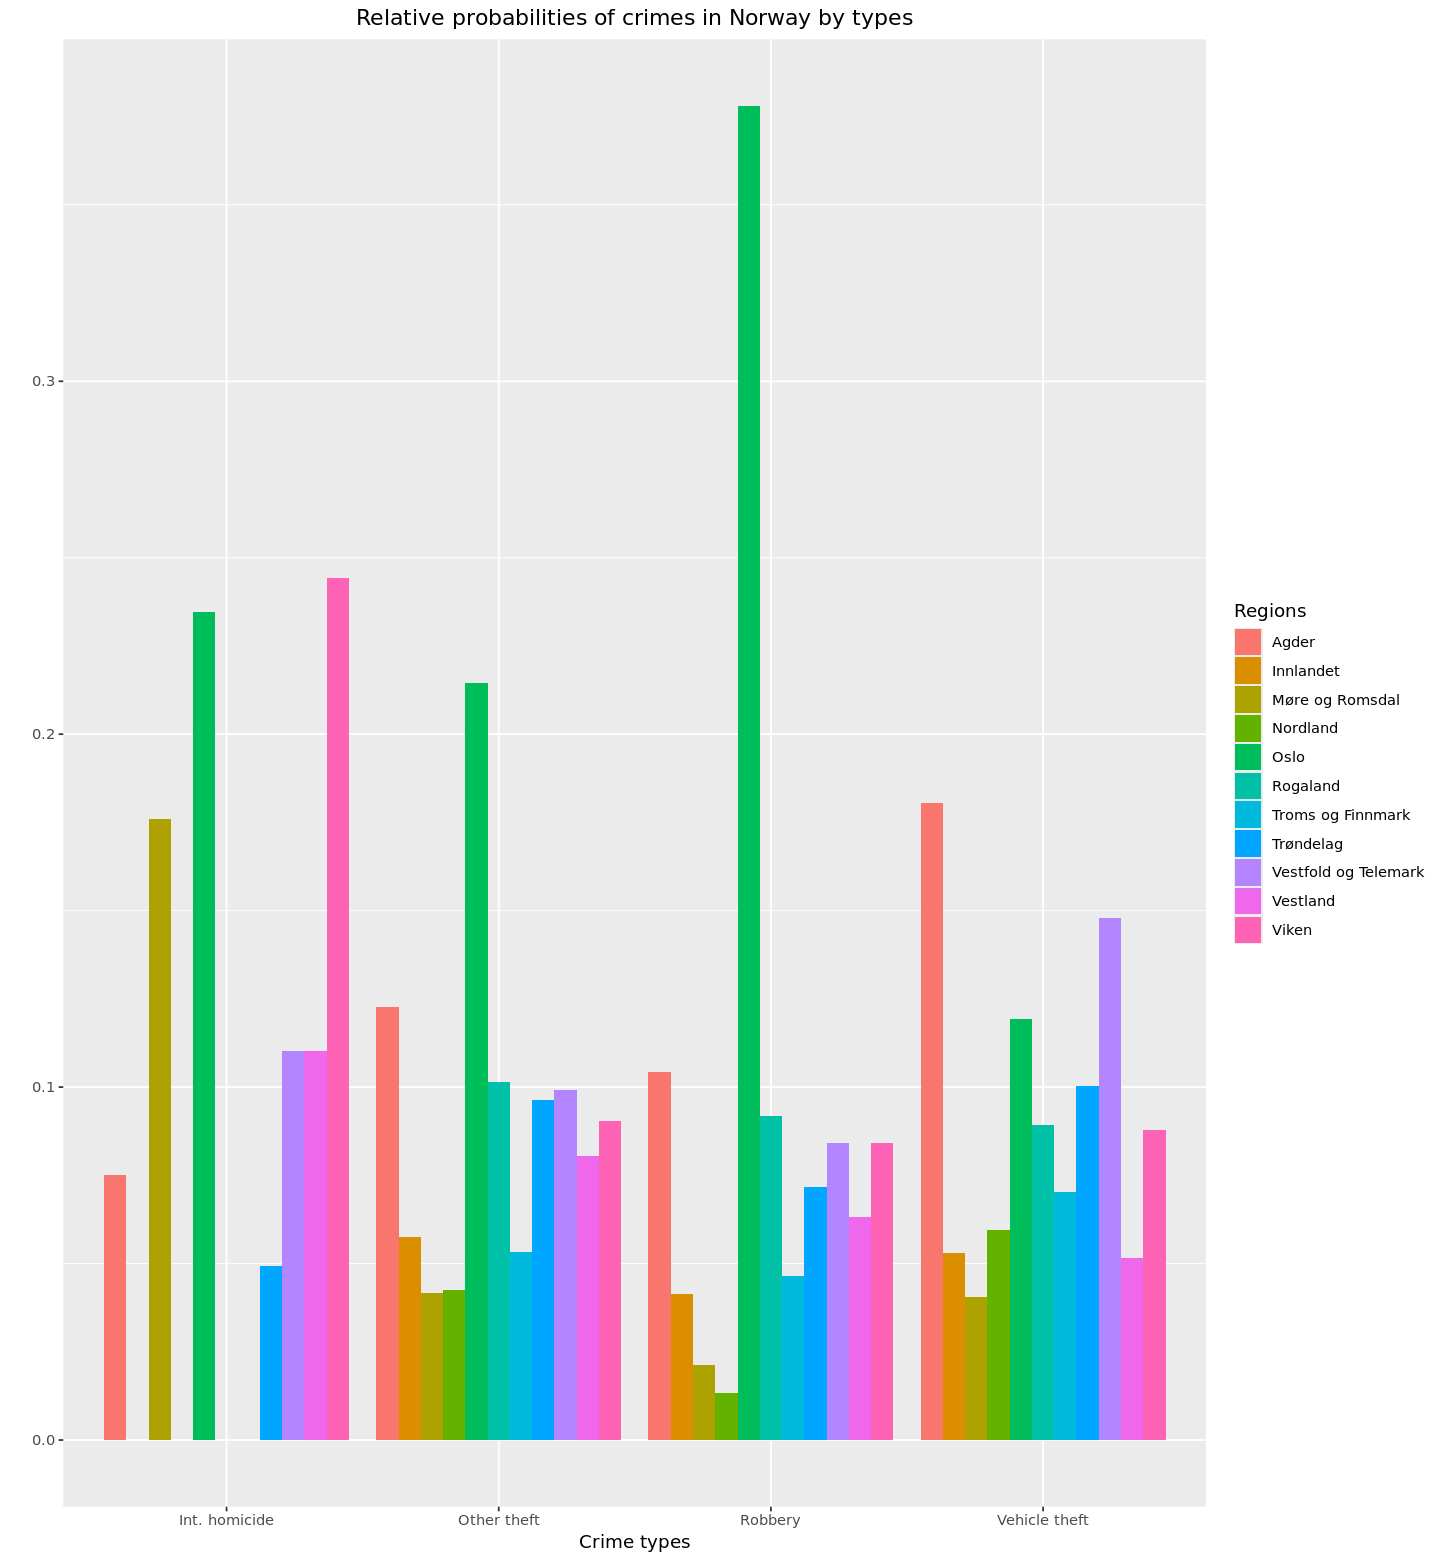

In [13]:
options(repr.plot.width=12, repr.plot.height=13) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by types', y='', x = 'Crime types', # Changes a title & axes of a plot
         fill="Regions" ) + # Changes a title of a legend
    theme(plot.title=element_text(hjust=0.5)) # Centers a title of a plot

This plot depicts a **distribution of probability** of crimes by types in regions of Norway. Looking at the probabilities of each crime happening in a specific region, we can highlight these facts which immediately catch the eye:

- **A robbery, a theft** is most likely to happen in **Oslo**
- **An int. homicide** is most likely to happen in **Viken**
- **A theft of a vehicle** is most likely to happen in **Adger**
- **Nordland** is the region with the least relative number of crimes.
- At the same time **Oslo** looks like the region which **dominates with its relative amount of crimes** throughout **almost all** categories.

\* all statements are related to the year of $2021$

## Contingency table

### Visual analysis of tables

Let's create contingency table - matrix of probabilities or frequencies - to see joined distribution or joint frequencies of two random variables across each category of each variable.

Now we will create contingency table across **iccs** and **geo** variables using absolute number of crime cases. But later we will use relative values, because they represent rate of particular crime taking also in consideration population size.

In [14]:
ct_abs <- xtabs(formula = abs ~ iccs + geo, data=data)
ct_abs

               geo
iccs            Østfold Akershus Oslo og Akershus Hedmark Oppland Buskerud
  Int. homicide       0        1                0       0       7       13
  Robbery            19       42                4      14     327      131
  Other theft      3046     6515             1491    1878   21030    16214
  Vehicle theft     122      294               89     106     518      684
               geo
iccs            Vestfold Telemark Aust-Agder Vest-Agder Rogaland
  Int. homicide        2        1          0          3        2
  Robbery             44       40         55         50        7
  Other theft       6125     5538       6973       7256     1580
  Vehicle theft      388      347        268        205       67

In each cell we can observe absolute number of crime cases of particular crime type in particular NUTS3 region in year $2021$.

In our data we have one problem - Theft crime type contains also all thefts of vehicle, because theft of vehicle is a subtype. Therefore, we will subtract surplus thefts from Theft type.


In [15]:
ct_abs['Other theft',] <- ct_abs['Other theft',] - ct_abs['Vehicle theft',]

In [16]:
ct_abs

               geo
iccs            Østfold Akershus Oslo og Akershus Hedmark Oppland Buskerud
  Int. homicide       0        1                0       0       7       13
  Robbery            19       42                4      14     327      131
  Other theft      2924     6221             1402    1772   20512    15530
  Vehicle theft     122      294               89     106     518      684
               geo
iccs            Vestfold Telemark Aust-Agder Vest-Agder Rogaland
  Int. homicide        2        1          0          3        2
  Robbery             44       40         55         50        7
  Other theft       5737     5191       6705       7051     1513
  Vehicle theft      388      347        268        205       67

We will add margins to see also total crime cases for each crime type and for each region.

In [17]:
addmargins(ct_abs)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0,1,0,0,7,13,2,1,0,3,2,29
Robbery,19,42,4,14,327,131,44,40,55,50,7,733
Other theft,2924,6221,1402,1772,20512,15530,5737,5191,6705,7051,1513,74558
Vehicle theft,122,294,89,106,518,684,388,347,268,205,67,3088
Sum,3065,6558,1495,1892,21364,16358,6171,5579,7028,7309,1589,78408


For example, we can observe, that in total there were $78408$ crime cases for all given crime types across all regions for year $2021$, most of them - $74558$ were thefts. The biggest number of thefts were in NO081 (Oslo, capital city of Norway) - $20512$ cases.

Let's now create contingency table with empirical probabilities:

In [18]:
round(addmargins(prop.table(ct_abs)), digits=5)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0.00000,0.00001,0.00000,0.00000,0.00009,0.00017,0.00003,0.00001,0.00000,0.00004,0.00003,0.00037
Robbery,0.00024,0.00054,0.00005,0.00018,0.00417,0.00167,0.00056,0.00051,0.00070,0.00064,0.00009,0.00935
Other theft,0.03729,0.07934,0.01788,0.02260,0.26161,0.19807,0.07317,0.06620,0.08551,0.08993,0.01930,0.95090
Vehicle theft,0.00156,0.00375,0.00114,0.00135,0.00661,0.00872,0.00495,0.00443,0.00342,0.00261,0.00085,0.03938
Sum,0.03909,0.08364,0.01907,0.02413,0.27247,0.20863,0.07870,0.07115,0.08963,0.09322,0.02027,1.00000


We rounded table with $5$ digits precision after floating point, because for this precision non-zero probabilities for Intentional homicide are not $0$ in the table, and it is more readable.

Each cell represents empirical probability $P(Crime\ type, Region)$, except margins, which represent empirical probability $P(Crime\ type)$ or $P(Region)$.

We can observe, that the most criminal region is NO081 (Oslo) with probability $\approx 0.272$ of crime occurrence in this region.

Now we can see the main problem of absolute values - it makes sense that in Oslo, which has very high population, there will be the highest probability of theft. Therefore, we will now create contingency tables for relative values and will use them for further analysis.

In [19]:
ct_rel <- xtabs(formula=rel ~ iccs + geo, data=data)
ct_rel['Other theft',] <- ct_rel['Other theft',] - ct_rel['Vehicle theft',]
addmargins(ct_rel)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0.00,0.21,0.00,0.00,1.00,1.04,0.47,0.32,0.00,0.47,0.75,4.26
Robbery,5.13,8.91,1.66,5.78,46.91,10.46,10.43,12.95,11.40,7.83,2.64,124.10
Other theft,788.98,1320.46,583.33,731.72,2942.85,1240.03,1359.86,1680.79,1389.22,1103.75,569.77,13710.76
Vehicle theft,32.92,62.40,37.03,43.77,74.32,54.62,91.97,112.35,55.53,32.09,25.23,622.23
Sum,827.03,1391.98,622.02,781.27,3065.08,1306.15,1462.73,1806.41,1456.15,1144.14,598.39,14461.35


From dataset description, we know that relative values represent the rate by $100,000$ population size. This means that the absolute cases number should be divided by factor of $100,000$ for whole population size in the region. For population size $420,000$ the factor will be $4.2$.

This means that relative values take into consideration the population size.

In [20]:
round(addmargins(proportions(ct_rel)), digits=5)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0.00000,0.00001,0.00000,0.00000,0.00007,0.00007,0.00003,0.00002,0.00000,0.00003,0.00005,0.00029
Robbery,0.00035,0.00062,0.00011,0.00040,0.00324,0.00072,0.00072,0.00090,0.00079,0.00054,0.00018,0.00858
Other theft,0.05456,0.09131,0.04034,0.05060,0.20350,0.08575,0.09403,0.11623,0.09606,0.07632,0.03940,0.94810
Vehicle theft,0.00228,0.00431,0.00256,0.00303,0.00514,0.00378,0.00636,0.00777,0.00384,0.00222,0.00174,0.04303
Sum,0.05719,0.09626,0.04301,0.05402,0.21195,0.09032,0.10115,0.12491,0.10069,0.07912,0.04138,1.00000


Again, we see that $P(Region = \text{NO081}) \approx 0.212$ - still Oslo has the highest probability for some crime to occur.

Analyzing further probabilities, we can observe interesting details:
- NO081 (Oslo) has the highest crime probability $(\approx 0.212)$ and rate $(3065.08)$.
- NO0A3 (Møre og Romsdal) has the least crime probability $(\approx 0.041)$ and rate $(598.39)$, just a little bit ahead from NO071 (Nordland) with prob. $\approx 0.043$ and rate $=	622.02$.
- Theft is the most frequent crime (prob. $\approx 0.95$ and rate $= 13710.76$).
- Intentional homicide is the least frequent crime (prob. $\approx 0.0003$ and rate $= 4.26$).

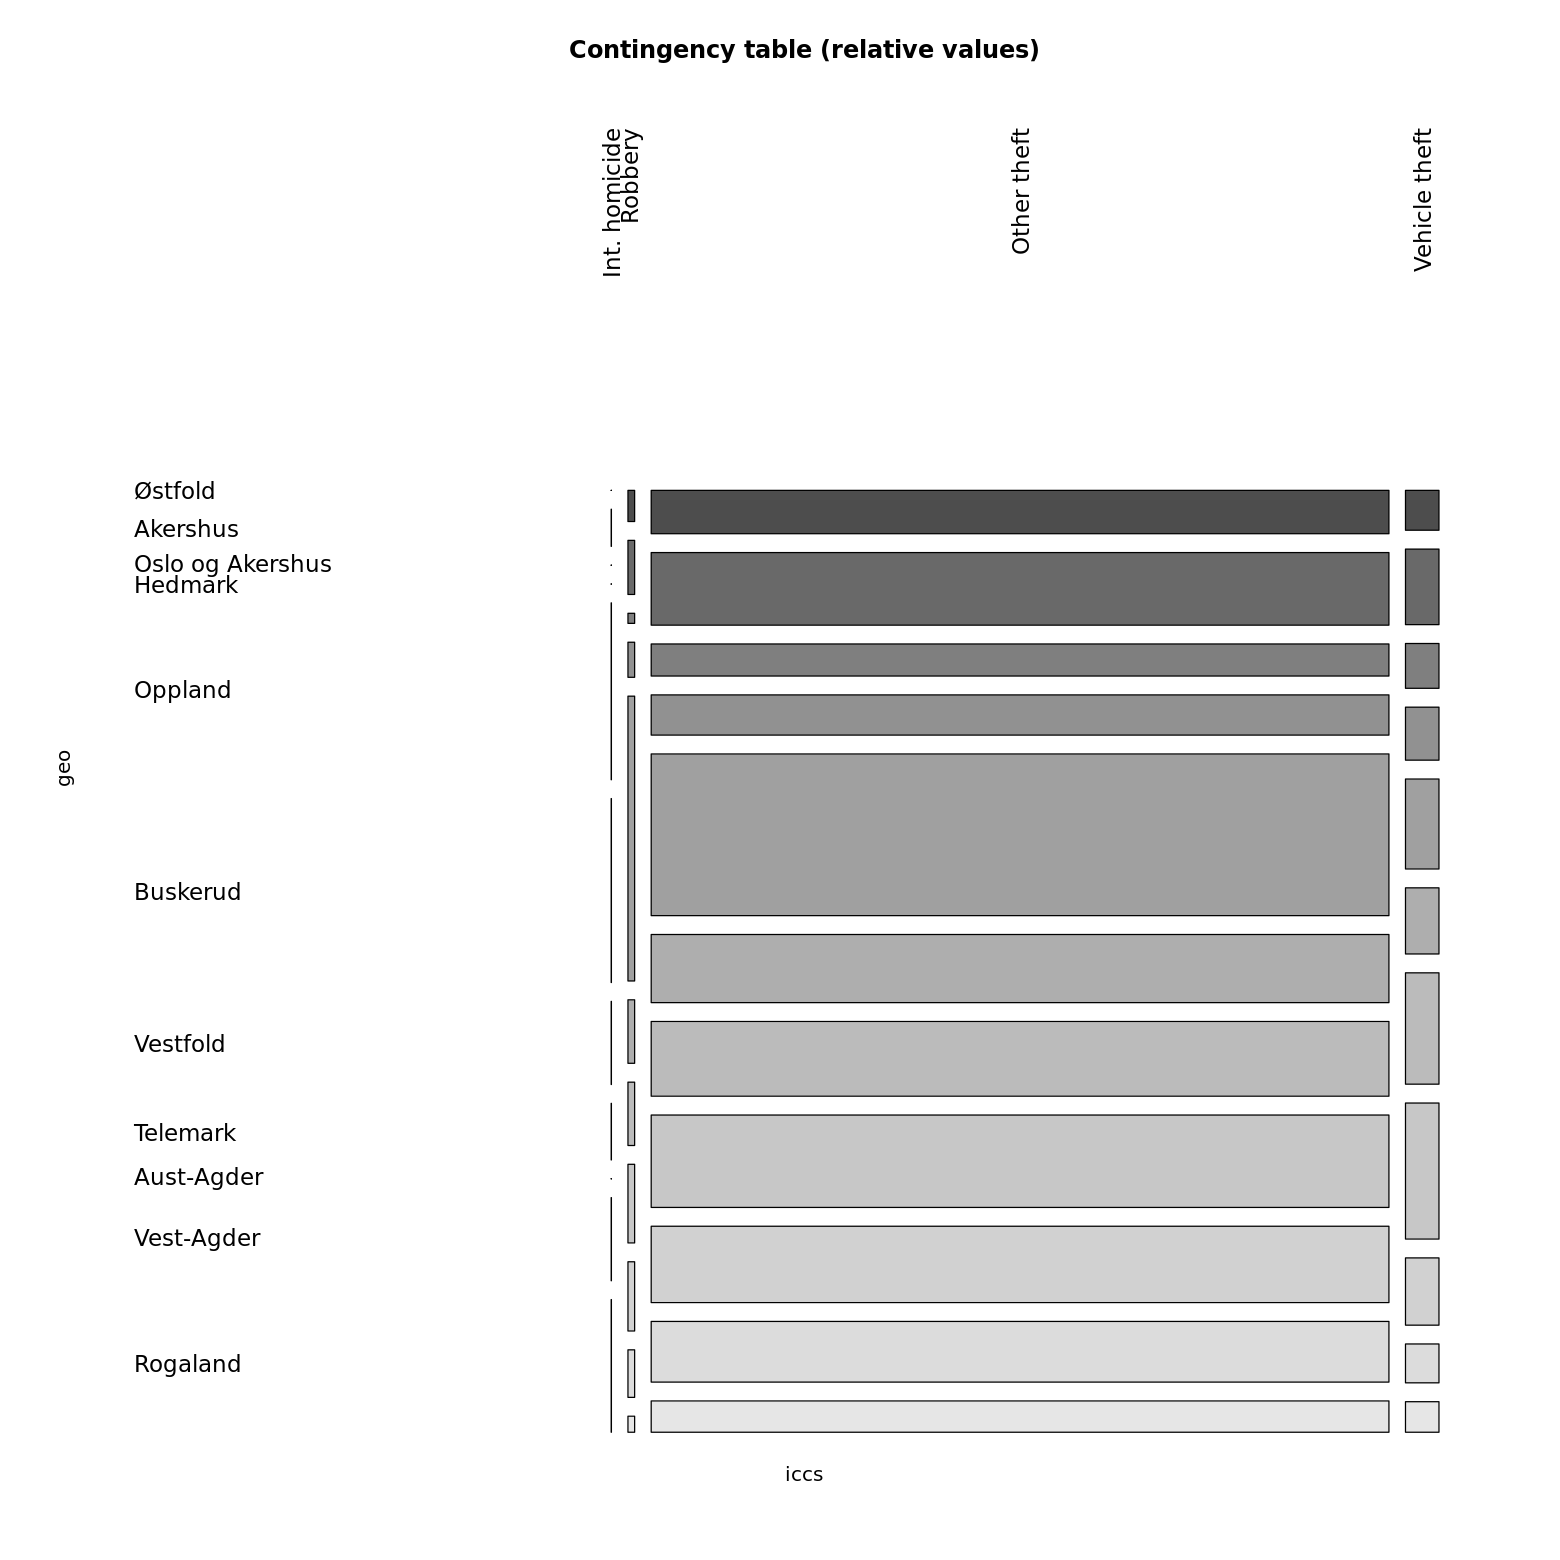

In [21]:
options(repr.plot.width=13, repr.plot.height=13) # Regulates the size of a plot
mosaicplot(ct_rel, color=T, main='Contingency table (relative values)', las=2, cex.axis=1.15)

On the plot we can observe more visually the empirical joint distribution. Along $x$-axis we have crime types, starting with intentional homicide, then robbery and then the rest.

### Hypotheses for tables

Now lets accomplish test of independence - what we want to test is whether random variables **iccs** and **geo** are independent.

For this let's use Pearson's $\chi^2$ test:

#### Pearson's $\chi^2$ test

- $H_0$: $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$: the $H_0$ does not hold

In [22]:
out <- chisq.test(ct_rel)
out

Warning message in chisq.test(ct_rel):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  ct_rel
X-squared = 97.257, df = 30, p-value = 5.009e-09


In [23]:
addmargins(out$observed)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0.00,0.21,0.00,0.00,1.00,1.04,0.47,0.32,0.00,0.47,0.75,4.26
Robbery,5.13,8.91,1.66,5.78,46.91,10.46,10.43,12.95,11.40,7.83,2.64,124.10
Other theft,788.98,1320.46,583.33,731.72,2942.85,1240.03,1359.86,1680.79,1389.22,1103.75,569.77,13710.76
Vehicle theft,32.92,62.40,37.03,43.77,74.32,54.62,91.97,112.35,55.53,32.09,25.23,622.23
Sum,827.03,1391.98,622.02,781.27,3065.08,1306.15,1462.73,1806.41,1456.15,1144.14,598.39,14461.35


In [24]:
round((addmargins(out$expected)), digits=3)

,Østfold,Akershus,Oslo og Akershus,Hedmark,Oppland,Buskerud,Vestfold,Telemark,Aust-Agder,Vest-Agder,Rogaland,Sum
Int. homicide,0.244,0.410,0.183,0.230,0.903,0.385,0.431,0.532,0.429,0.337,0.176,4.26
Robbery,7.097,11.945,5.338,6.704,26.303,11.209,12.552,15.502,12.496,9.818,5.135,124.10
Other theft,784.105,1319.732,589.735,740.720,2905.993,1238.357,1386.810,1712.652,1380.571,1084.755,567.332,13710.76
Vehicle theft,35.585,59.893,26.764,33.616,131.882,56.200,62.937,77.725,62.654,49.229,25.747,622.23
Sum,827.030,1391.980,622.020,781.270,3065.080,1306.150,1462.730,1806.410,1456.150,1144.140,598.390,14461.35


From expected frequencies we can observe, that not all cells have values $\geq 5$, for example $n_{11} = 0.244 \lt 5 $. This is an important premise to use the Pearson $\chi^2$ test, even when running the test we had a warning that approximation of the test may be incorrect, because values are two low.

Also, in table not all values are integers, this test would work better with absolute values, but in this situation we won't take into consideration population density.

#### Homogenity of multinomial distributions test

Now let's test homogenity of multinomial distributions:
- $H_0$: row probabilities $p_{i1}, \ldots, p_{i\cdot}$ are not dependent on $i$
- $H_A$: $H_0$ does not hold

For this test we already have test statistics from the previous test:$$\chi^2 = n \sum_{i=1}^r \sum_{j=1}^c \frac{n_{ij}^2}{n_{i\cdot} n_{\cdot j}} -n = 97.257.$$

If $\chi^2 \geq \chi_{(r-1)(c-1)}^2(\alpha)$, $H_0$ is rejected.

In [25]:
alpha <- 0.05
rows <- nrow(ct_rel)
cols <- ncol(ct_rel)

df <- (rows - 1) * (cols - 1)

critical_value <- qchisq(1 - alpha, df)
round(critical_value, digits=3)

[1] 43.773

We see that:  $\chi^2 = 97.257 \geq  43.773 = \chi_{(r-1)(c-1)}^2(\alpha)$.
So the $H_0$ is rejected in preference for the alternative $H_A$, that row distributions are dependent on crime type - in other words - distributions of each crime type across every region are not the same, distribution of Theft crime type across all regions is not the same as distribution of Intentional homicide across all regions.

#### Fisher exact test

Because Pearson's $\chi^2$ test doesn't have fulfilled its premise, to test independence of the random variables we will also use the Fisher exact test:

- $H_0$: $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$: the $H_0$ does not hold

In [26]:
fisher.test(ct_rel, simulate.p.value=T)

Warning message in fisher.test(ct_rel, simulate.p.value = T):
“'x' has been rounded to integer: Mean relative difference: 0.0006521281”



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  ct_rel
p-value = 0.0004998
alternative hypothesis: two.sided


We have a warning here, because the test works with integers, so it will round automatically all values in the table. We think that still it is better to analyze the relative data, though for example for Intentional homicide the rounding can be quite proportionally high.

We see that the p-value is much less than the standard $\alpha$ - $0.0004998 \lt 0.05$ - so we reject $H_0$ in preference for the alternative $H_A$, that given random variables are not independent.

## Hypotheses and tests

### Test #1 (Total criminality comparison - 2020 vs 2021)

In this test we will use **Mann-Whitney U test** and **Kolmogorov-Smirnov two-sample test** to test whether criminality distribution is same or significantly different between years $2020$ and $2021$.

#### Data preparation

We will use absolute values - first of all, lets gather some data and look at it for the test.

In [27]:
data.2021 <- subset(dataset,
                    startsWith(geo, 'NO') &
                    nchar(geo) == 5 &
                    TIME_PERIOD == '2021-01-01' &
                    unit == 'NR',
                    c(iccs, geo, values))

data.2020 <- subset(dataset,
                    startsWith(geo, 'NO') &
                    nchar(geo) == 5 &
                    TIME_PERIOD == '2020-01-01' &
                    unit == 'NR',
                    c(iccs, geo, values))

prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Other theft', 'Vehicle theft')

data.2021$iccs <- factor(data.2021$iccs, levels=prev_labels, labels=new_labels)
data.2020$iccs <- factor(data.2020$iccs, levels=prev_labels, labels=new_labels)
head(data.2020, 3)
head(data.2021, 3)

iccs,geo,values
<fct>,<chr>,<dbl>
Int. homicide,NO020,3
Int. homicide,NO060,2
Int. homicide,NO071,0


iccs,geo,values
<fct>,<chr>,<dbl>
Int. homicide,NO020,0
Int. homicide,NO060,1
Int. homicide,NO071,0


Now we need to subtract Vehicle theft from Other theft, because we now that Vehicle theft is a subtype of Other theft, and Other theft contains crimes duplicated from Vehicle theft.

In [28]:
wide_data.2020 <- pivot_wider(data.2020, names_from=geo, values_from=values)
wide_data.2020[3,-1] <- wide_data.2020[3, -1] - wide_data.2020[4,-1]
cols = colnames(wide_data.2020)[-1]
prepared_data.2020 <- pivot_longer(wide_data.2020, cols=cols, names_to='geo', values_to='values')
prepared_data.2020$year = '2020'

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols)

  # Now:
  data %>% select(all_of(cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [29]:
wide_data.2021 <- pivot_wider(data.2021, names_from=geo, values_from=values)
wide_data.2021[3,-1] <- wide_data.2021[3, -1] - wide_data.2021[4,-1]
cols = colnames(wide_data.2021)[-1]
prepared_data.2021 <- pivot_longer(wide_data.2021, cols=cols, names_to='geo', values_to='values')
prepared_data.2021$year = '2021'

In [30]:
# convert year to factor, because we have only two values as categories - 2020 and 2021
prepared_data.2021$year <- factor(prepared_data.2021$year)
prepared_data.2020$year <- factor(prepared_data.2020$year)

data_total_crimes <- rbind(prepared_data.2020, prepared_data.2021)

In [31]:
head(data_total_crimes)
tail(data_total_crimes)

iccs,geo,values,year
<fct>,<chr>,<dbl>,<fct>
Int. homicide,NO020,3,2020
Int. homicide,NO060,2,2020
Int. homicide,NO071,0,2020
Int. homicide,NO074,0,2020
Int. homicide,NO081,2,2020
Int. homicide,NO082,10,2020


iccs,geo,values,year
<fct>,<chr>,<dbl>,<fct>
Vehicle theft,NO082,684,2021
Vehicle theft,NO091,388,2021
Vehicle theft,NO092,347,2021
Vehicle theft,NO0A1,268,2021
Vehicle theft,NO0A2,205,2021
Vehicle theft,NO0A3,67,2021


#### Mann-Whitney U test

In Mann-Whitney U test we assume that we have two distribution functions:
- $F_{2021}$ - for crimes across all types and regions by year 2021.
- $F_{2020}$ - for crimes across all types and regions by year 2020.

We test:
- $H_0: F_{2021} = F_{2020}$
- $H_A: F_{2021} \neq F_{2020}$

In other words - we test if crime situation in Norway didn't change significantly between year $2020$ and $2021$.

Man-Whitney U test is sensitive to data translation, that is $G(x) = F(x-\delta), \delta>0$, so we will assume that crime cases are not shifted (no bias in measuring of data).


In [32]:
wilcox.test(values ~ year, data=data_total_crimes)

Warning message in wilcox.test.default(x = c(3, 2, 0, 0, 2, 10, 1, 3, 5, 5, 0, 12, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  values by year
W = 999.5, p-value = 0.7958
alternative hypothesis: true location shift is not equal to 0


We can se the warning - "cannot compute exact p-value with ties". This situation occurs because some values, or ranks, are same in the data. Though R will use approximation for the p-value, still we should be careful, because we don't have now exact the p-value.

Nonetheless, the p-value is much higher than $\alpha$, thus we cannot reject the null hypothesis in favor of alternative that distributions are significantly different.

#### Kolmogorov-Smirnov two-sample test

Let's check same test using Kolmogorov-Smirnov two-sample test:
- $H_0: F_{2021} = F_{2020}$
- $H_A: F_{2021} \neq F_{2020}$

Kolmogorov-Smirnov two-sample test compares empiric distribution functions from both distributions.
Lets create those empiric distribution functions, so we can compare what we see visually with what the test states:

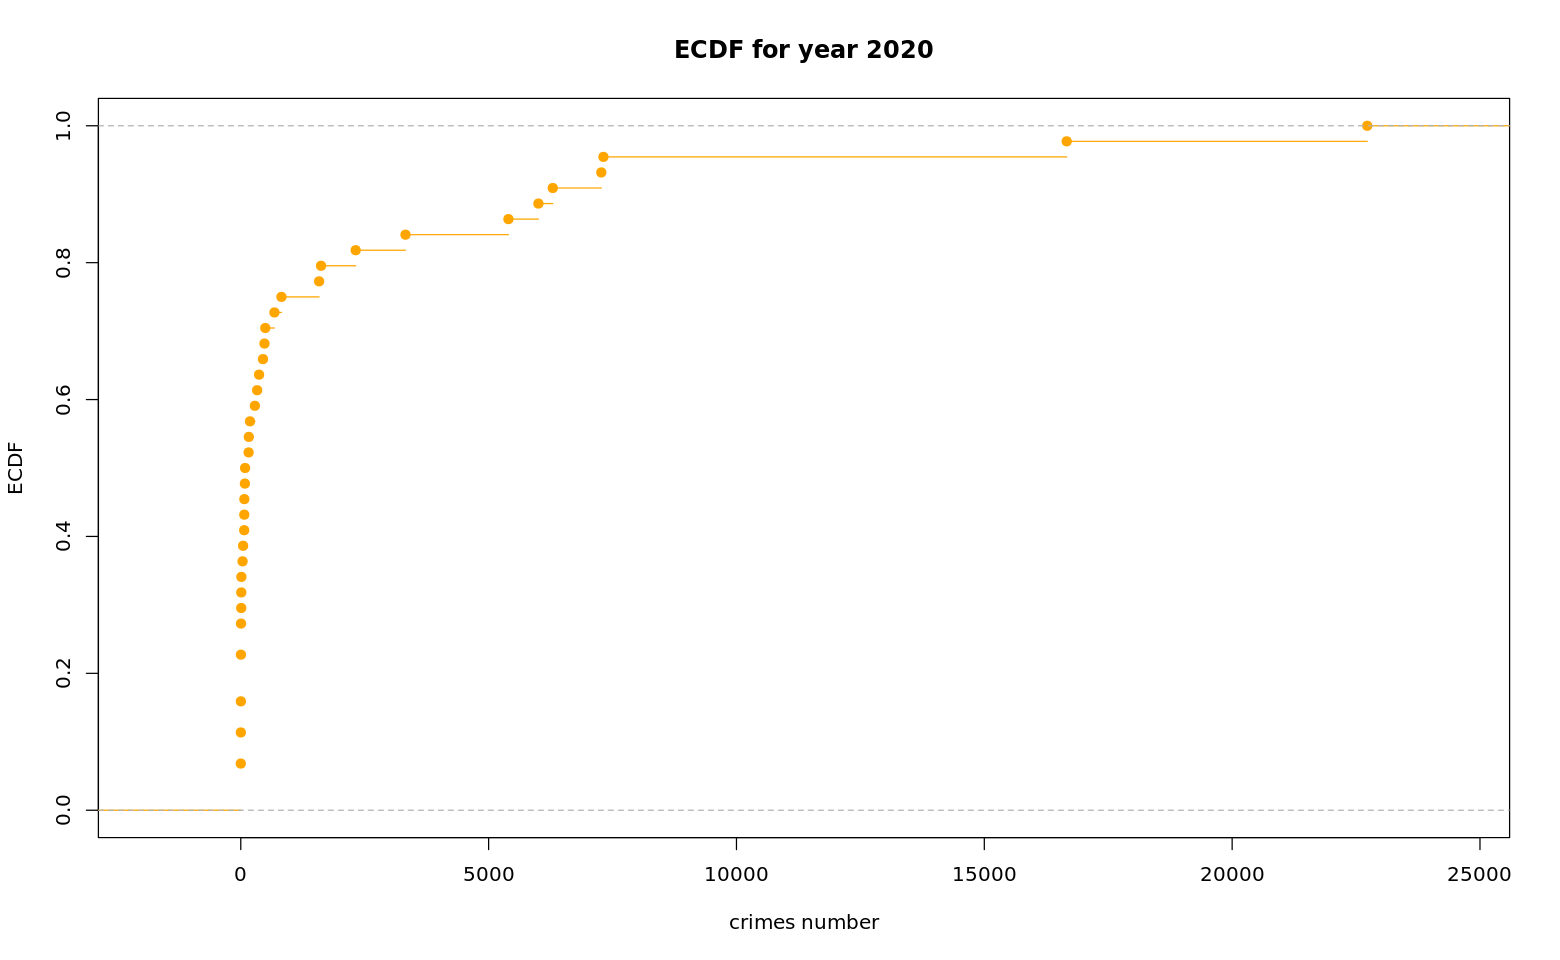

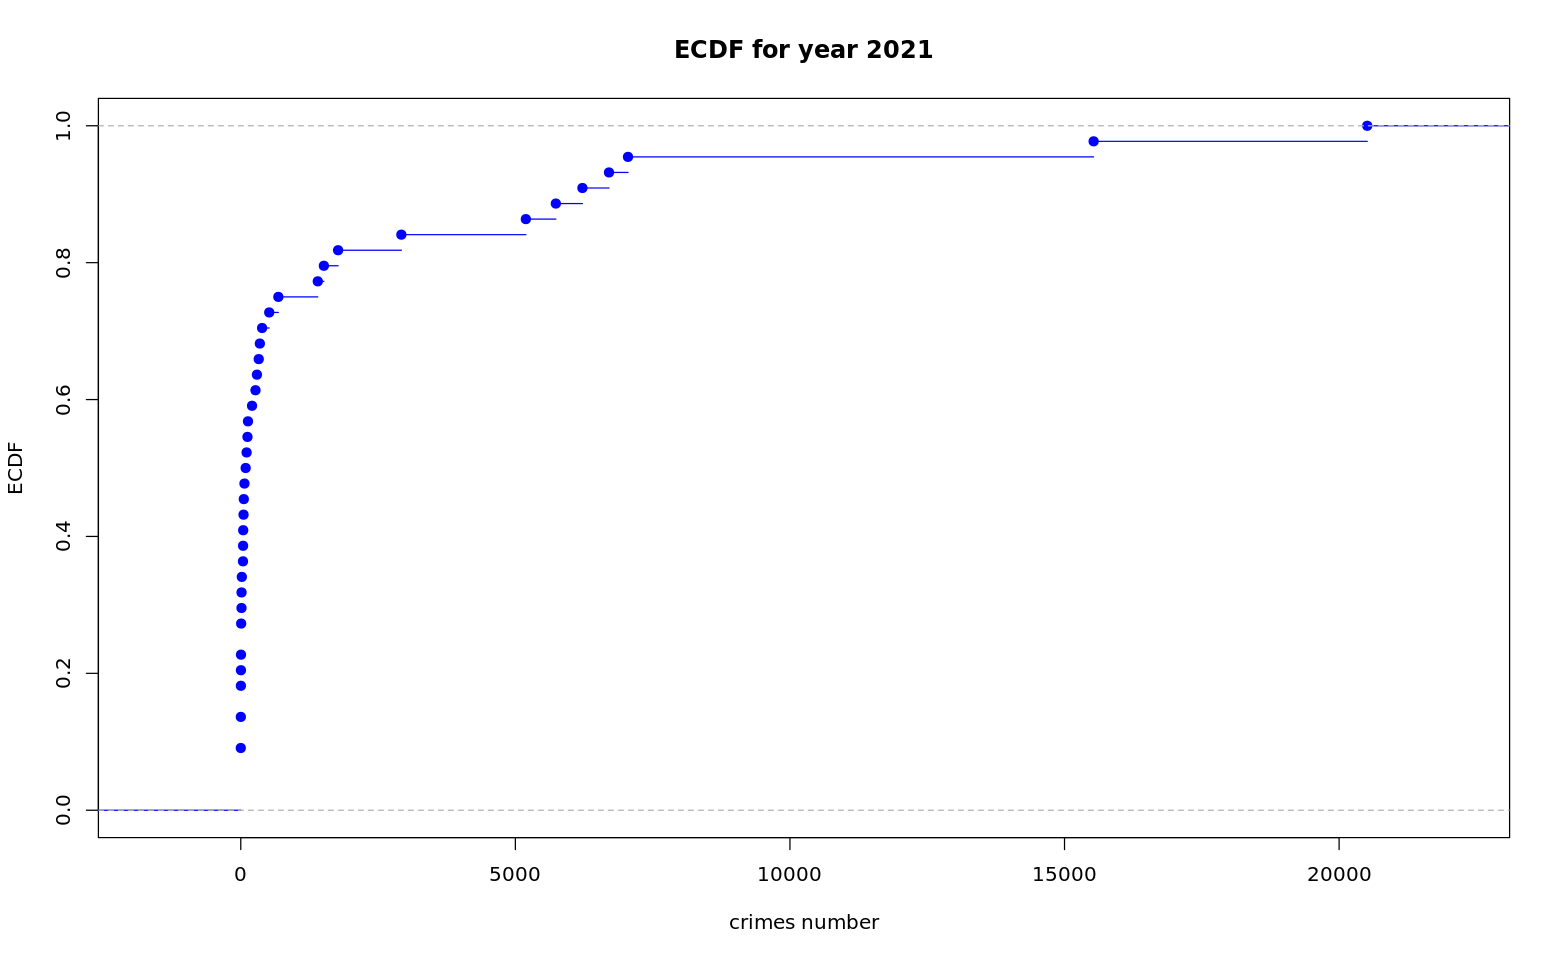

In [33]:
options(repr.plot.width=13, repr.plot.height=8) # Regulates the size of a plot
plot(ecdf(prepared_data.2020$values), main='ECDF for year 2020', xlab='crimes number', ylab='ECDF', col='orange')
plot(ecdf(prepared_data.2021$values), main='ECDF for year 2021', xlab='crimes number', ylab='ECDF', col='blue')

For better comparison of both distribution functions, we will plot them together on one plot. **Note, that technically following plots are not distribution functions, because of vertical lines.** But for visual comparison it is much better.

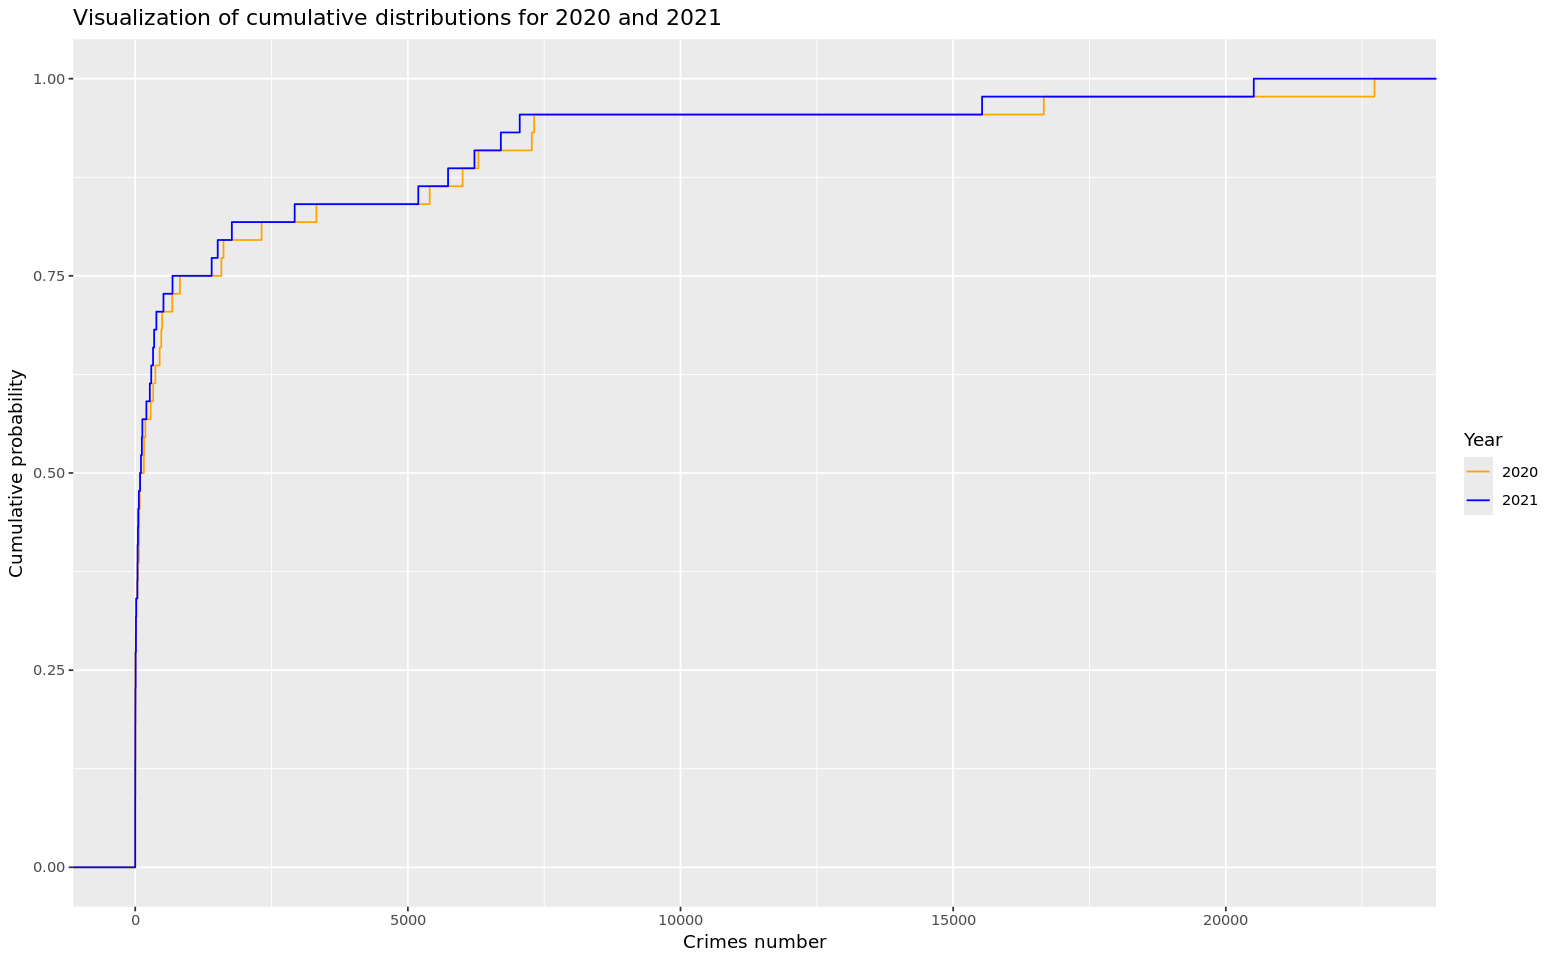

In [34]:
options(repr.plot.width=13, repr.plot.height=8) # Regulates the size of a plot
ggplot(data_total_crimes, aes(x=values, group=year, color=year)) +
  stat_ecdf(geom='step') +
  labs(title='Visualization of cumulative distributions for 2020 and 2021',
       x='Crimes number',
       y='Cumulative probability',
       color='Year') +
  scale_color_manual(values=c('2020'='orange', '2021'='blue'))

In [35]:
ks.test(values ~ year, data=data_total_crimes)

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'language'”


ERROR: Error in ks.test(values ~ year, data = data_total_crimes): argument "y" is missing, with no default


P-value is much higher that the $\alpha$, thus we cannot reject null hypothesis.

Visually we see, that both empirical distribution functions are almost identical, which supports the conclusion that we cannot reject that distributions are significantly different.

To conclude - we cannot say that criminality distribution between $2020$ and $2021$ years is significantly different.

### Test #2 (2008 vs 2019)

#### Intuition

This part will examine whether there is a relationship between the number of crimes and time. First, let us consider the intuition why such a test might have meaning.

For this task, we will choose capital region data between $2008$ and $2019$. The regional division was changed after $2019$, so we cannot consider the more recent data along with the older ones, which is simply a larger number. Additionally, in this case, it makes sense to consider absolute values, since this is the same region and its population has not changed much over this period of time.

In [ ]:
crime_dynamics <- subset(dataset,
                         geo == 'NO011' & unit == 'NR',
                         c(iccs, TIME_PERIOD, values))
crime_dynamics <- pivot_wider(crime_dynamics, names_from=iccs, values_from=values)
crime_dynamics$ICCS0502 <- crime_dynamics$ICCS0502 - crime_dynamics$ICCS050211  # solution of the same problem with subset
all(colnames(crime_dynamics)[-1] == prev_labels)  # justification for the following line of code
colnames(crime_dynamics)[-1] <- new_labels

In [ ]:
crime_dynamics

As can be seen from the dataframe above there is a downward trend in crime. The following visualization demonstrates this better.

In [ ]:
options(repr.plot.width=13, repr.plot.height=8)
ggplot(crime_dynamics %>% pivot_longer(cols=new_labels,
                                       names_to='crime',
                                       values_to='values'),
       aes(x=TIME_PERIOD, y=values, color=crime)) +
    geom_line() +
    scale_x_date(breaks=crime_dynamics$TIME_PERIOD, date_labels='%Y') +
    scale_y_continuous(trans='log10') +
    labs(title='Crimes in the capital region by year',
         x='Year',
         y='Number of cases (log scale)',
         color='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5))

Special attention should be paid to the fact that the y-axis has log scaling. The changes over time are actually impressive. This is confirmed by further examination of $2008$ and $2019$ separately.

In [ ]:
freq_time_vs_crime_df <- subset(crime_dynamics, TIME_PERIOD %in% c('2008-01-01', '2019-01-01'))
freq_time_vs_crime_table <- (freq_time_vs_crime_df %>% column_to_rownames('TIME_PERIOD') %>% as.matrix() %>% as.table())
names(dimnames(freq_time_vs_crime_table)) <- c('year', 'crime')

In [ ]:
dark_grey <- '#555555'

In [ ]:
ggplot(as.data.frame(freq_time_vs_crime_table), aes(x=year, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=format(freq_time_vs_crime_df$TIME_PERIOD, '%Y')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in 2008 and 2019 (capital region)',
         x='Year',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

The number of cases has decreased by times. Let's check the statistical significance of these changes.

#### Statistical significance

In this instance, the existence of independence between the two variables **year** and **crime** is investigated. Both are qualitative, so it makes sense to look at the contingency table `freq_time_vs_crime_table` to select a statistical test.

In [ ]:
freq_time_vs_crime_table

In [ ]:
sum(freq_time_vs_crime_table)  # N

Let's start by defining the matrix of **observed** frequencies $\mathbf O \in \mathbb N^{2,4}$ (`freq_time_vs_crime_table`) and the matrix of **expected** frequencies $\mathbf E \in \mathbb N^{2,4}$ as follows$$(\forall i \in \hat n)(\forall j \in \hat m)\left(\mathbf E_{ij} = \frac{f_{i\cdot} \cdot f_{\cdot j}}{N}\right),$$where $n=2, m=4$ and the expression on the right denotes dividing the **marginal frequencies** by the total number of observations. For example$$\begin{align*}\mathbf E_
{21} = \frac{f_{2\cdot} \cdot f_{\cdot 1}}{N} = \frac{4075 \cdot 13}{47050} \approx 1.126 < 5 && (*)\end{align*}$$

The hypotheses will look as follows$$\begin{align*} H_0: \ \mathbf O = \mathbf E  && \text{(variables are independent)} \\ H_A: \ \mathbf O \ne \mathbf E \end{align*}$$

*Because of this inequality Pearson's chi-squared test cannot be applied on this data, we use Fisher's exact test instead.\
**An analog in probabilities can be given to the expressions above.

In [ ]:
fisher.test(freq_time_vs_crime_table, alternative='only in the 2x2 case', simulate.p.value=T)

Fisher's test uses a hypergeometric distribution to accurately calculate the probability of obtaining such data conditional on $H_0$ being true. In our case, this probability is $0.0005$, which is less than the accepted significance level of $0.05$. This means that we reject the null hypothesis in favor of the alternative.

## Test #3 (Norway vs Finland)

### Intuition

Let's examine the difference in crime rates between Norway and Finland for $2021.$ This can be done on the basis of absolute values, since the populations of these countries are almost equal — $5.408$ million for [Norway](https://www.google.com/search?q=norway+population+2021&sca_esv=6dba56f94bcc106c&sca_upv=1&sxsrf=ACQVn09RNlOaFd8FlhssUGT3EgBV155UgA%3A1711713537425&ei=Aa0GZuK_Gf7bi-gP9Nm6oAI&ved=0ahUKEwiixOvqtZmFAxX-7QIHHfSsDiQQ4dUDCBA&uact=5&oq=norway+population+2021&gs_lp=Egxnd3Mtd2l6LXNlcnAiFm5vcndheSBwb3B1bGF0aW9uIDIwMjEyCBAAGAcYHhgKMgYQABgHGB4yBhAAGAUYHjIGEAAYCBgeMgYQABgIGB5IxxdQwAlYkBZwA3gBkAEAmAFPoAHpA6oBATe4AQPIAQD4AQGYAgqgApUEwgIKEAAYRxjWBBiwA8ICDRAAGIAEGIoFGEMYsAPCAggQABgIGAcYHsICCBAAGAUYBxgewgILEAAYgAQYigUYhgPCAgUQABiABJgDAIgGAZAGCpIHAjEwoAePIw&sclient=gws-wiz-serp) and $5.541$ million for [Finland](https://www.google.com/search?q=finland+population+2021&sca_esv=6dba56f94bcc106c&sca_upv=1&sxsrf=ACQVn09kzkR_WVOdaUguEGXsF7Zm_6H58A%3A1711713567653&ei=H60GZrbAJ6Lbi-gPhvioyAo&ved=0ahUKEwj2y6D5tZmFAxWi7QIHHQY8CqkQ4dUDCBA&uact=5&oq=finland+population+2021&gs_lp=Egxnd3Mtd2l6LXNlcnAiF2ZpbmxhbmQgcG9wdWxhdGlvbiAyMDIxMg8QIxiABBiKBRgnGEYY-wEyBhAAGAgYHjIZEAAYgAQYigUYRhj7ARiXBRiMBRjdBNgBAUieFFD2B1juDnACeAGQAQCYAbUBoAGpBaoBAzYuMbgBA8gBAPgBAZgCCKACqgTCAgoQABhHGNYEGLADwgINEAAYgAQYigUYQxiwA8ICBhAAGAcYHsICCBAAGAgYBxgewgIIEAAYBRgHGB7CAgwQIxiwAhgnGEYY-wHCAhYQABiwAhhGGPsBGJcFGIwFGN0E2AEBmAMAiAYBkAYKugYGCAEQARgTkgcBOKAHkSU&sclient=gws-wiz-serp).

We will look at three categories of crimes and will not include theft of a motor vehicle separately, as these data are not available for Finland.

In [ ]:
freq_no_vs_fi_crime_df <- subset(dataset,
                                 geo %in% c('NO', 'FI') &
                                 iccs %in% prev_labels[-4] &
                                 TIME_PERIOD == '2021-01-01' &
                                 unit == 'NR',
                                 c(geo, iccs, values))
freq_no_vs_fi_crime_df <- pivot_wider(freq_no_vs_fi_crime_df, names_from=iccs, values_from=values)
colnames(freq_no_vs_fi_crime_df)[-1] <- c('Int. homicide', 'Robbery', 'Theft')

In [ ]:
freq_no_vs_fi_crime_table <- (freq_no_vs_fi_crime_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_no_vs_fi_crime_table)) <- c('country', 'crime')

In [ ]:
ggplot(as.data.frame(freq_no_vs_fi_crime_table), aes(x=country, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=c('Finland', 'Norway')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in Finland and Norway in 2021',
         x='Country',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title = element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

There is a big difference in the crime rate in these two countries. Let's check this statistically.

### Statistical significance

The hypotheses will be the same as in the last test$$\begin{align*} H_0: \ \mathbf O = \mathbf E  && \text{(variables are independent)} \\ H_A: \ \mathbf O \ne \mathbf E \end{align*}$$The only difference is that the data will change — $\mathbf O, \mathbf E \in \mathbb N^{2,3}.$ In addition, we can now apply Pearson's chi-squared test since all elements of matrix $\mathbf E$ are greater than or equal to $5$.

In [ ]:
freq_no_vs_fi_crime_table

In [ ]:
test_output <- chisq.test(freq_no_vs_fi_crime_table)
round(test_output$expected, digits=2)

In [ ]:
test_output

The p-value allows us to reject the null hypothesis in favor of the alternative. This means that the difference in crime between the two countries is statistically significant.

## References

1. ***Eurostat, Column description is located in 'About this dataset' section,*** https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
2. ***Eurostat, Dataset metadata (Completeness section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
3. ***Eurostat, Dataset metadata (Unit of measure section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
4. ***Eurostat, International classification od crime (codes)***, https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
5. ***Revolutions, Regulation of the size of a plot***, https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
6. ***EU guidelines for the International Classification of Crime for Statistical Purposes — ICCS***, https://ec.europa.eu/eurostat/documents/3859598/8305054/KS-GQ-17-010-EN-N.pdf/feefb266-becc-441c-8283-3f9f74b29156?t=1507884966000